# KBC Construction with NER

Code adapted from: https://www.depends-on-the-definition.com/guide-sequence-tagging-neural-networks-python/

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('drive')

### Load and Explore the NER Dataset

In [ ]:
data = pd.read_csv('combined_data_v8.csv')
data = data.fillna(method = 'ffill')

In [ ]:
print("What the dataset looks like:")
data.head(10)

What the dataset looks like:


,Sentence #,Word,POS,Agila_DB_tag
0,1,A,DET,O
1,1,central,ADJ,B-hwp
2,1,processing,NOUN,I-hwp
3,1,unit,NOUN,I-hwp
4,1,(,PUNCT,O
5,1,CPU,PROPN,B-hwp
6,1,),PUNCT,O
7,1,",",PUNCT,O
8,1,also,ADV,O
9,1,called,VERB,O


##Counting sentence,unique words and Tags

In [ ]:
data['Sentence #'].value_counts()

722     366
636     194
689     187
809     173
1536    156
       ... 
276       1
1236      1
0         1
581       1
737       1
Name: Sentence #, Length: 2307, dtype: int64

In [ ]:
uniques = data['Sentence #'].unique()
for i in range(1, 2254):
  if i not in uniques:
    print(i)

In [ ]:
print('unique words in corpus:', data['Word'].nunique())
print('unique tags in corpus', data['Agila_DB_tag'].nunique())
print('unique tags in dataset:', data['Agila_DB_tag'].unique())

unique words in corpus: 6538
unique tags in corpus 21
unique tags in dataset: ['O' 'B-hwp' 'I-hwp' 'B-func' 'B-sw' 'I-sw' 'I-func' 'B-hwsp' 'I-hwsp'
 'B-qt' 'B-sys' 'B-comp' 'I-sys' 'B-unit' 'I-comp' 'B-mea' 'I-qt' 'B-hwc'
 'I-hwc' 'I-unit' 'I-mea']


In [ ]:
search_val=["B-hwp","B-comp","B-hwc","B-hwsp","B-sw","B-sys","B-mea","B-unit","B-func","B-qt"]
search_dict={}
for k in search_val:
    search_dict[k] = 0 #count

for item in data.itertuples():
    if pd.isnull(item[4]):
        continue
    
    for k in search_dict.keys():
        if k in item[4]:
            search_dict[k]=search_dict[k]+1
        
print(search_dict)

{'B-hwp': 1426, 'B-comp': 319, 'B-hwc': 902, 'B-hwsp': 362, 'B-sw': 364, 'B-sys': 583, 'B-mea': 400, 'B-unit': 520, 'B-func': 597, 'B-qt': 1770}


In [ ]:
sum(search_dict.values())

7243

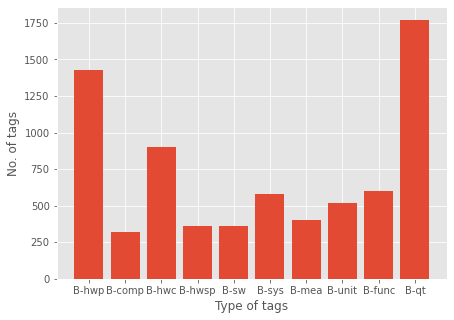

In [ ]:
f, ax = plt.subplots(figsize=(7,5))
plt.bar(search_dict.keys(), search_dict.values(), align='center')
plt.xlabel('Type of tags')
plt.ylabel('No. of tags')
plt.show()

In [ ]:
counting_tag=data["Agila_DB_tag"].value_counts()
counting_tag

O         52615
B-qt       1770
B-hwp      1426
I-hwp       967
I-qt        946
I-hwc       940
B-hwc       902
B-func      597
B-sys       583
I-sys       540
B-unit      520
I-func      520
B-mea       400
B-sw        364
B-hwsp      362
B-comp      319
I-hwsp      264
I-sw        214
I-comp      196
I-unit      130
I-mea         7
Name: Agila_DB_tag, dtype: int64

# padding token to end of unique words

In [ ]:
words = list(set(data['Word'].values))
words.append("ENDPAD")
num_words = len(words)

In [ ]:
tags = list(set(data['Agila_DB_tag'].values))
num_tags = len(tags)

In [ ]:
num_words, num_tags

(6539, 21)

##Now use a Class which would convert every sentence with its named entities (tags) into a list of tuples [(word,named entity),(word,named entity),.. …].

we will create a class that will retrieve the sentences and their corresponding tags so that we can clearly define the input and output to our Neural Network Model.

We’ll start with 1 sentence and group them using the lambda function.First select the sentence from “word” column, see their values, and convert them into list and repeat this process for "Part Of Speech" and "Agila_DB_tag" columns.

Then we’ll apply this aggregated function to our sentences. Later we’ll split that entire list into sub-lists.

In [ ]:

class SentenceGetter(object):
    """Retrieves sentences and their corresponding tags."""
    def __init__(self, data):
        # counter to track the number of sentences
        self.n_sent = 1
        # initialize data
        self.data = data
        # grouping sentences into tuples of 3 values:
        # first value: words, second value: pos, third value: ner_tag
        aggregate_function = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                                    s['POS'].values.tolist(),
                                                                    s['Agila_DB_tag'].values.tolist())]
        #aggregate_function = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Agila_DB_tag"].values.tolist())]
        # applying the aggregate_function() to the sentences
        self.grouped = self.data.groupby('Sentence #').apply(aggregate_function)
        self.sentences = [s for s in self.grouped]

In [ ]:
getter = SentenceGetter(data)

In [ ]:
sentences = getter.sentences

In [ ]:
print('This is how a sentence looks like:--------------------------------')
sentences[2]

This is how a sentence looks like:--------------------------------


[('The', 'DET', 'O'),
 ('CPU', 'NOUN', 'B-hwp'),
 ('performs', 'VERB', 'O'),
 ('basic', 'ADJ', 'O'),
 ('arithmetic', 'ADJ', 'B-func'),
 (',', 'PUNCT', 'O'),
 ('logic', 'NOUN', 'B-func'),
 (',', 'PUNCT', 'O'),
 ('controlling', 'VERB', 'B-func'),
 (',', 'PUNCT', 'O'),
 ('and', 'CCONJ', 'O'),
 ('input', 'NOUN', 'B-func'),
 ('/', 'SYM', 'I-func'),
 ('output', 'NOUN', 'I-func'),
 ('operations', 'NOUN', 'I-func'),
 ('specified', 'VERB', 'O'),
 ('by', 'ADP', 'O'),
 ('the', 'DET', 'O'),
 ('instructions', 'NOUN', 'B-sw'),
 ('in', 'ADP', 'O'),
 ('the', 'DET', 'O'),
 ('program', 'NOUN', 'B-sw'),
 ('.', 'PUNCT', 'O')]

In [ ]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 366 words


# Plot sentence by length

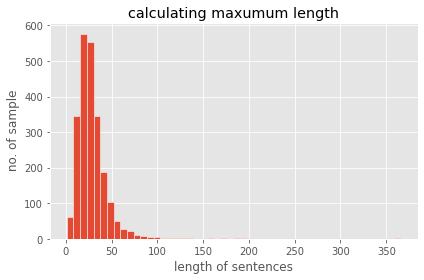

In [ ]:
plt.hist([len(s) for s in sentences],bins=50,edgecolor="white")
plt.title("calculating maxumum length")
plt.xlabel("length of sentences")
plt.ylabel(" no. of sample")
plt.tight_layout()
plt.show()

* Since we see that the mean of sentence length is about 20-21,
* We can choose something safer: value of around 50 would mean.The machine will add a generic word for the empty spaces and sequences longer than 50 will be truncated. 


In [ ]:
max_len = 50

### Define Mappings between Sentences and Tags
* Dictionary to represent words & Agila_DB_tags as numerical values or indices.creating word-to-index and index-to-word mapping which is necessary for conversions for words before training (and after prediction).Here, we are going to build two dictionaries. one is to represent words as numerical values and second is to representing our tags as numerical values.

In [ ]:
word_to_index = {w: i + 1 for i, w in enumerate(words)}
tag_to_index = {t: i for i, t in enumerate(tags)}

In [ ]:
print(word_to_index)

{'conflict': 1, '\r\n\r\n  \r\n    \r\n      \r\n        \r\n          ': 2, 'attributed': 3, '0.464': 4, 'ACC': 5, 'hobbyists': 6, 'correctional': 7, 'Repeated': 8, '38': 9, 'safety': 10, 'tandem': 11, 'Signals': 12, 'lag': 13, 'encode': 14, 'likely': 15, 'reliable': 16, 'adopted': 17, 'Inputs': 18, 'Converter': 19, 'United': 20, 'programmer': 21, '\r\n        \r\n          ': 22, '1980s': 23, 'exclusively': 24, 'performed': 25, 'desktops': 26, 'Amiga': 27, 'usual': 28, 'Xbox': 29, 'autotransformers': 30, 'regulates': 31, '99': 32, 'Thesis': 33, 'revenue': 34, 'avionics': 35, 'term': 36, 'George': 37, 'prevent': 38, 'Jitter': 39, 'conductor': 40, 'RISC': 41, 'newest': 42, 'distort': 43, 'isolator': 44, 'categories': 45, 'sub-$100': 46, '10': 47, 'supercomputers': 48, 'addressing': 49, 'Placing': 50, 'Distronic': 51, 'predictable': 52, 'simultaneously': 53, 'Mohamed': 54, 'transformerless': 55, '0.1': 56, 'surface': 57, 'alloy': 58, 'inodes': 59, 'Combined': 60, 'increases': 61, 'selec

In [ ]:

print(tag_to_index)

{'B-unit': 0, 'I-mea': 1, 'I-comp': 2, 'B-func': 3, 'B-sys': 4, 'B-comp': 5, 'I-hwc': 6, 'O': 7, 'B-hwsp': 8, 'I-hwsp': 9, 'I-sys': 10, 'B-mea': 11, 'I-sw': 12, 'I-unit': 13, 'I-qt': 14, 'B-hwp': 15, 'I-func': 16, 'B-qt': 17, 'I-hwp': 18, 'B-sw': 19, 'B-hwc': 20}


##Saving index number of words and tags for further use

In [ ]:
with open('/content/drive/My Drive/Thesis/Pickle file/word_to_indexCombinedDataForTest.pkl', 'wb') as f:
    pickle.dump(word_to_index, f)

In [ ]:
with open('/content/drive/My Drive/Thesis/Pickle file/tag_to_indexCombinedDataForTest.pkl', 'wb') as f:
     pickle.dump(tag_to_index, f)

Check the new two columns

In [ ]:
data['Word_to_idx'] = data['Word'].map(word_to_index)
data['Tag_to_idx'] = data['Agila_DB_tag'].map(tag_to_index)
data.head(15)

,Sentence #,Word,POS,Agila_DB_tag,Word_to_idx,Tag_to_idx
0,1,A,DET,O,837,6
1,1,central,ADJ,B-hwp,3338,16
2,1,processing,NOUN,I-hwp,3631,2
3,1,unit,NOUN,I-hwp,6041,2
4,1,(,PUNCT,O,4065,6
5,1,CPU,PROPN,B-hwp,4841,16
6,1,),PUNCT,O,5380,6
7,1,",",PUNCT,O,3816,6
8,1,also,ADV,O,3093,6
9,1,called,VERB,O,6532,6


#Using one hot encoding for word embeddings and vector representation.

In [ ]:
max_len = 50
X = [[word_to_index[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag_to_index[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag_to_index["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [ ]:
X.shape

(2307, 50)

In [ ]:
# creation of test/train data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

1845 1845
462 462


## Build and Compile a Bidirectional LSTM Model for knowlwdgw base

In [ ]:
import keras
import keras.utils
from keras import utils as np_utils

In [ ]:
from tensorflow.keras import Model, Input
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [ ]:
input_word = Input(shape=(max_len,))
KB_LSTM_model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
KB_LSTM_model = SpatialDropout1D(0.1)(KB_LSTM_model)
KB_LSTM_model = Bidirectional(LSTM(units=256, return_sequences=True, recurrent_dropout=0.1))(KB_LSTM_model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(KB_LSTM_model)
KB_LSTM_model = Model(input_word, out)
KB_LSTM_model.summary()
KB_LSTM_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            326950    
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 512)          628736    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 21)           10773     
 ibuted)                                                         
                                                             

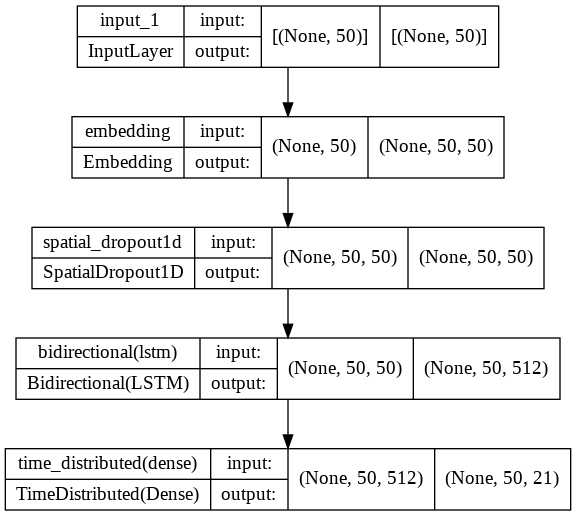

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(KB_LSTM_model,show_shapes= True)

In [ ]:
KB_LSTM_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.models import Sequential

### Train the Model(with training data)

In [ ]:
!pip install livelossplot
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 45.6 MB/s 


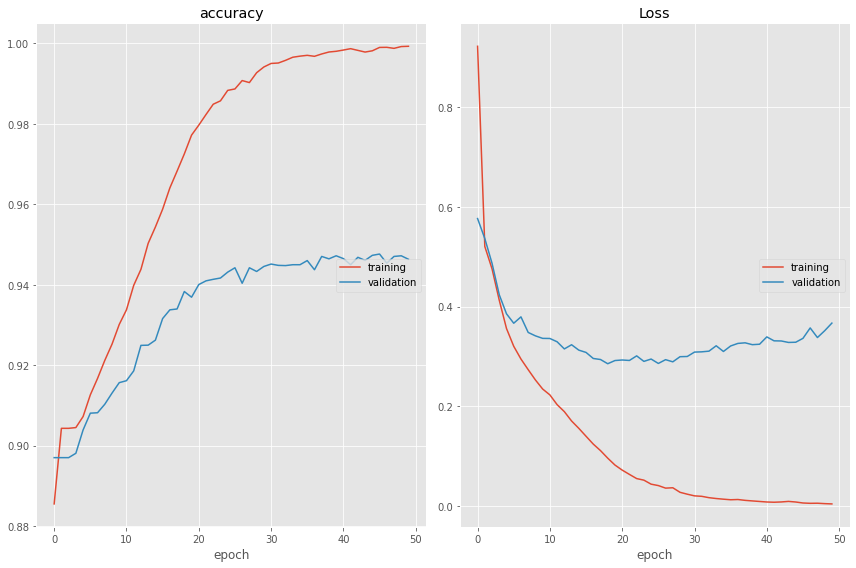

accuracy
	training         	 (min:    0.886, max:    0.999, cur:    0.999)
	validation       	 (min:    0.897, max:    0.948, cur:    0.946)
Loss
	training         	 (min:    0.004, max:    0.922, cur:    0.004)
	validation       	 (min:    0.285, max:    0.577, cur:    0.367)
47/47 [==============================] - 18s 379ms/step - loss: 0.0041 - accuracy: 0.9993 - val_loss: 0.3669 - val_accuracy: 0.9463


In [ ]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 1, verbose = 0, mode = 'max', restore_best_weights=False)
callbacks = [PlotLossesCallback()] #early_stopping]

history = KB_LSTM_model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size=32,
    epochs=50, 
    verbose=1, 
    callbacks=callbacks
)

In [ ]:
prediction = KB_LSTM_model.predict(x_test)#prediction with test data
pred = np.argmax(prediction, axis=-1)
y_test_true = np.argmax(y_test, -1)

In [ ]:
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.5 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=5ebf2182b34caea855ba4d2868cbae7d7845cb551dadf16c598b7bc8940845e3
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
from sklearn.metrics import classification_report
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

#Convert the index number again to tag

In [ ]:
#token_index -> Value:word
idx2word = {i: w for w, i in word_to_index.items()}
#tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag_to_index.items()}

In [ ]:
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_test_true_tag = [[idx2tag[i] for i in row] for row in y_test_true] 

In [ ]:
report =classification_report(pred_tag,y_test_true_tag) #for new data
print(report)

              precision    recall  f1-score   support

        comp       0.65      0.63      0.64        51
        func       0.35      0.38      0.36        98
         hwc       0.66      0.59      0.62       193
         hwp       0.65      0.64      0.64       307
        hwsp       0.56      0.52      0.54        77
         mea       0.68      0.88      0.77        72
          qt       0.73      0.67      0.70       402
          sw       0.51      0.58      0.54        57
         sys       0.46      0.53      0.49        86
        unit       0.75      0.81      0.78       116

   micro avg       0.64      0.64      0.64      1459
   macro avg       0.60      0.62      0.61      1459
weighted avg       0.64      0.64      0.64      1459



In [ ]:
print("F1-score: {:.1%}".format(f1_score(pred_tag,y_test_true_tag)))

F1-score: 63.6%


#saving the model

In [ ]:
KB_LSTM_model.save('/content/drive/My Drive/Thesis/model save/KB_LSTM_model_C8_50.h5')

In [ ]:
from google.colab import drive
drive.mount('drive')
list_words = []
list_tags_true =[]
list_tags_pred =[]

# loop -----------------------------
for i in range(x_test.shape[0]):
  # i = np.random.randint(0, x_test.shape[0])#choose a random number between 0 and len(X_te)
  preds = model.predict(np.array([x_test[i]]))
  pred = np.argmax(preds, axis=-1)

  y_true = np.argmax(np.array(y_test), axis=-1)[i]

  #for Visualization
  # print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
  # print("-"*50)

  for w, true, p in zip(x_test[i], y_true, pred[0]):
    if w != "ENDPAD":
      # print("{:15}{}\t{}".format(words[w-1], tags[true], tags[p]))
      list_words.append(words[w-1])
      list_tags_true.append(tags[true])
      list_tags_pred.append(tags[p])
# /loop -----------------------------

table = pd.DataFrame({'Word':list_words,'True':list_tags_true,'Pred':list_tags_pred})
#print(table.to_string())
table.to_csv('/content/drive/My Drive/Thesis/Training_result/final_prediction.csv')